In [20]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Mar  4 19:38:18 2018
@author: pablorr10
"""

import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import norm
%matplotlib inline

class Punto:
    '''
    Punto en el espacio de n dimensiones definido por sus coordenadas (x1,...xN)
    '''
    def __init__(self, coordenadas):
        self.coordenadas = coordenadas
        self.dimension = len(coordenadas)
        
    def __repr__(self):
        return 'Coordinadas: ' + str(self.coordenadas) + \
               '\n\t -> Dimesiones: ' + str(self.dimension)
               
             
                
class Cluster:
    '''
    Conjunto de puntos pertenecientes a la misma distribución
    '''
    def __init__(self, puntos, total_puntos):
        '''
        Inicialización del cluster, asignación de puntos y cáculo de sus parámetros
        '''
        # Nos aseguramos de que hay al menos 1 punto
        assert(len(puntos) > 0)
        self.puntos = puntos
        self.dimension = puntos[0].dimension
        
        # Nos aseguramos de que todos los puntos del Cluster tienen las mismas dimensiones
        for p in puntos:
            if p.dimension != self.dimension:
                raise Exception('Todos los puntos han de tener las mismas dimensiones!')
                
        # Calculamos los parámetros de la distribución del cluster en función de sus puntos
        coordenadas_puntos = [p.coordenadas for p in self.puntos]
        self.mu = np.mean(coordenadas_puntos, axis=0)
        self.sigma = np.array([1.0, 1.0])
        self.probabilidad_pertenencia = len(self.puntos) / float(total_puntos)
        self.convergencia = False
        
    def actualizar_valores(self, puntos, total_puntos):
        '''
        Método para actualizar los valores del cluster tras el paso de maximización
        '''
        mu_previa = self.mu
        self.puntos = puntos
        coordenadas_puntos = [p.coordenadas for p in self.puntos]
        self.mu = np.mean(coordenadas_puntos, axis=0)
        self.sigma = np.std(coordenadas_puntos, axis=0, ddof=1)
        self.probabilidad_pertenencia = len(self.puntos) / float(total_puntos)
        self.convergencia = np.array_equal(mu_previa, self.mu)
        
    
def probabilidad_pertenencia(punto, cluster):
    '''
    Método que determina la probabilidad de que un punto pertenezca a un cluster
    en función de sus parámetros de distribución
    '''
    mu = cluster.mu
    sigma = cluster.sigma
    p = cluster.probabilidad_pertenencia
    
    for i in range(punto.dimension):
        p *= norm.pdf(punto.coordenadas[i], mu[i], sigma[i]) 
        #p *= (np.exp(-0.5 * (np.power((val[i] - mu[i]), 2) / np.power(sig[i][i], 2))) / sig[i][i])
    
    return p


def esperanza(punto, clusters):
    '''
    Método que calcula la esperanza de un punto de pertenecer a cada uno de los 
    clusters y devuelve el cluster (su índice) con mayor probabilidad
    '''
    esperanza = np.zeros(len(clusters))
    
    for i, cluster in enumerate(clusters):
        esperanza[i] = probabilidad_pertenencia(punto, cluster)
    return np.argmax(esperanza)


def dibujar_elipse(centro, puntos, alpha, color):
    '''
    Método que dibuja la forma elíptica de los clusters dados sus parámetros
    '''
    # Matriz de covarianza
    M_cov = np.cov(puntos, rowvar=False)
    
    # Autovalores y autovectores de la matriz de covarianza
    autovalores, autovector = np.linalg.eigh(M_cov)
    rango_matrix = autovalores.argsort()[::-1]
    autovector = autovector[:, rango_matrix]
    
    # Calcular el ángulo de la elipse dado los autovectores
    angulo = np.degrees(np.arctan2(*autovector[:,0][::-1]))
    
    # Calcular la altura y la anchura dados los autovalores
    ancho, alto = 4  * np.sqrt(autovalores[rango_matrix])
    
    # Construimos el objeto elipse
    elipse = Ellipse(xy=centro, width=ancho, height=alto, angle=angulo, 
                    alpha=alpha, color=color)
    
    ax = plt.gca()
    ax.add_artist(elipse)
    
    return elipse

def pintar_clusters(clusters):
    '''
    Método para dibujar los resultados
    '''
    plt.figure()
    for i, cluster in enumerate(clusters):
        # Para cada cluster
        
        # Dibujar los puntos de cada cluster
        x, y = zip(*[p.coordenadas for p in cluster.puntos])
        plt.scatter(x, y, color=colores[i], marker='.', s=2)
        
        # Dibujar los centroides
        plt.scatter(cluster.mu[0], cluster.mu[1], marker='P', s=300, c='k')
        
        # Dibujar elipse con la distribución
        dibujar_elipse(cluster.mu, [p.coordenadas for p in cluster.puntos], 0.4, colores[i])

    plt.show()

def esperanza_maximizacion(datos, num_clusters, iteraciones):
    '''
    Método que ejecuta la lógica del algoritmo EM
    '''
    puntos = datos
    
    # Asignación aleatoria inicial a los clusters
    inicial = random.sample(puntos, num_clusters)
    
    # Crear N clusters iniciales
    clusters = [Cluster([p], len(inicial)) for p in inicial]
    
    # Inicializar una lista donde guardaremos los puntos con sus nuevas asignaciones
    nuevos_puntos = [[] for i in range(num_clusters)]
    
    convergencia = False
    iteracion = 0
    inicio = time.time()
    
    while (not convergencia) and (iteracion < iteraciones):
        
        # Esperanza
        for p in puntos:
            i_cluster = esperanza(p, clusters)
            nuevos_puntos[i_cluster].append(p)
            
        # Maximizacion
        for i, c in enumerate(clusters):
            c.actualizar_valores(nuevos_puntos[i], len(puntos))
            
        # Comprobar convergencia
        covergencia = [c.convergencia for c in clusters].count(False) == 0
        
        # Incrementar el contador y limpiar lista
        iteracion += 1
        nuevos_puntos = [[] for i in range(num_clusters)]
        tiempo = time.time()
        print('Interación número: %d'  % (iteracion))
        print('Tiempo de ejecución: %.2f segundos' % ((tiempo-inicio)))
        
    pintar_clusters(clusters)

In [21]:
datos = pd.read_csv('./2d_data_clustering.csv') 
datos.columns = ['x', 'y']
datos.head()

,x,y
0,2.072345,-3.241693
1,17.936710,15.784810
2,1.083576,7.319176
3,11.120670,14.406780
4,23.711550,2.557729


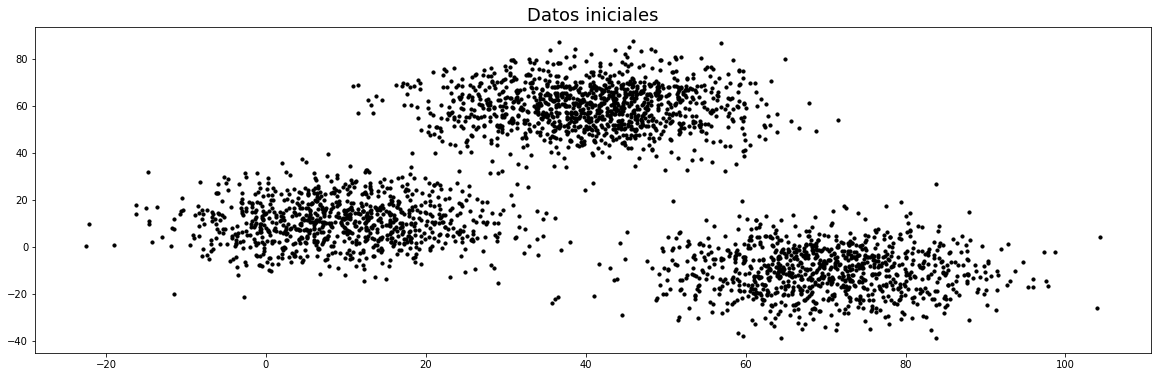

In [22]:
plt.figure(figsize=(20,6))
plt.title('Datos iniciales', fontsize=18)
plt.scatter(datos['x'], datos['y'], color='black', s=10)
plt.show()

Interación número: 1
Tiempo de ejecución: 1.74 segundos
Interación número: 2
Tiempo de ejecución: 3.42 segundos
Interación número: 3
Tiempo de ejecución: 5.08 segundos
Interación número: 4
Tiempo de ejecución: 6.79 segundos
Interación número: 5
Tiempo de ejecución: 8.54 segundos
Interación número: 6
Tiempo de ejecución: 10.22 segundos
Interación número: 7
Tiempo de ejecución: 11.87 segundos
Interación número: 8
Tiempo de ejecución: 13.52 segundos
Interación número: 9
Tiempo de ejecución: 15.27 segundos
Interación número: 10
Tiempo de ejecución: 17.06 segundos


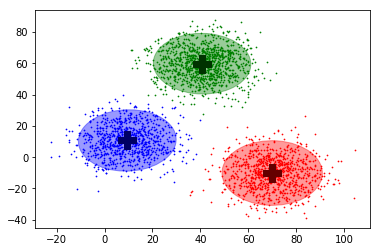

In [23]:
puntos = list()
valores = list(datos.values)
colores = ['red', 'blue', 'green']

for punto in valores:
    puntos.append(Punto(punto))

esperanza_maximizacion(puntos, 3, 10)  